## Comparing loss functions for different set of hyperparameters

More in-depth plots - comparing learning rates for different configurations as well as for data with augmentation and without augmentation.

In [ ]:
import mlflow
import numpy as np
import matplotlib.pyplot as plt

In [8]:
client = mlflow.tracking.MlflowClient()
cnn_no_augmentation = mlflow.get_experiment_by_name("CNN-no-augmentation")
cnn_augmentation = mlflow.get_experiment_by_name("CNN")

In [ ]:
no_aug_best = mlflow.search_runs(
    cnn_no_augmentation.experiment_id, filter_string='params.learning_rate = "0.1"'
)
no_aug_best_lr = mlflow.search_runs(
    cnn_no_augmentation.experiment_id, filter_string='params.learning_rate != "0.1"'
)
no_aug_best.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_f1_macro,metrics.test_auroc,metrics.val_loss_epoch,metrics.epoch,...,metrics.val_recall,metrics.val_f1_macro,params.learning_rate,params.weight_decay,params.dropout,params.batch_size,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.source.type
0,2b0e1df523fc4dd7b3b191821b98b6d9,486107824923468037,FINISHED,file:c:/Users/SPCX/Desktop/github-repositories...,2025-03-21 16:32:30.063000+00:00,2025-03-21 16:35:40.843000+00:00,0.781753,0.916413,1.389704,20.0,...,0.580378,0.583197,0.1,0.001,0.2,512,SPCX,c:\Users\SPCX\Desktop\github-repositories\dl-c...,powerful-crab-417,LOCAL
1,a8e2b051d1d54e6f8d6c6cf4f6170662,486107824923468037,FINISHED,file:c:/Users/SPCX/Desktop/github-repositories...,2025-03-21 16:29:18.981000+00:00,2025-03-21 16:32:30.041000+00:00,0.775575,0.916023,1.402017,20.0,...,0.575889,0.574087,0.1,0.001,0.2,512,SPCX,c:\Users\SPCX\Desktop\github-repositories\dl-c...,loud-grub-788,LOCAL
2,a5ceff2be2334b1a8df5c962fb77abbe,486107824923468037,FINISHED,file:c:/Users/SPCX/Desktop/github-repositories...,2025-03-21 16:26:02.854000+00:00,2025-03-21 16:29:18.959000+00:00,0.777722,0.916584,1.431757,20.0,...,0.579278,0.577598,0.1,0.001,0.2,512,SPCX,c:\Users\SPCX\Desktop\github-repositories\dl-c...,stately-hound-279,LOCAL
3,3d15ce1ab82a4758a09c94f7de8dc7e1,486107824923468037,FINISHED,file:c:/Users/SPCX/Desktop/github-repositories...,2025-03-21 16:22:52.772000+00:00,2025-03-21 16:26:02.832000+00:00,0.776031,0.916281,1.394573,20.0,...,0.584189,0.582210,0.1,0.001,0.2,512,SPCX,c:\Users\SPCX\Desktop\github-repositories\dl-c...,vaunted-tern-800,LOCAL
4,23ce38e1f4534e9eb076fbc2da18aa85,486107824923468037,FINISHED,file:c:/Users/SPCX/Desktop/github-repositories...,2025-03-21 16:19:42.907000+00:00,2025-03-21 16:22:52.749000+00:00,0.775621,0.916891,1.418856,20.0,...,0.584778,0.581935,0.1,0.001,0.2,512,SPCX,c:\Users\SPCX\Desktop\github-repositories\dl-c...,glamorous-hen-523,LOCAL


In [27]:
def get_per_step_value(run_id):
    train_loss = client.get_metric_history(run_id, "train_loss_epoch")
    train_loss_steps, train_loss_values = (
        [m.step for m in train_loss],
        [m.value for m in train_loss],
    )
    val_loss = client.get_metric_history(run_id, "val_loss_epoch")
    val_loss_steps, val_loss_values = (
        [m.step for m in val_loss],
        [m.value for m in val_loss],
    )
    return {
        "train_loss": (train_loss_steps, train_loss_values),
        "val_loss": (val_loss_steps, val_loss_values),
    }


def plot_results(
    aug_ids,
    other_ids,
    label1,
    label2,
    title,
    additional_ids=None,
    additional_label=None,
):
    all_train_loss_aug = []
    all_val_loss_aug = []
    steps1 = None
    steps2 = None
    all_train_loss_no_aug = []
    all_val_loss_no_aug = []
    for run_id_aug, run_id_no_aug in zip(aug_ids, other_ids):
        metrics_aug = get_per_step_value(run_id_aug)
        train_loss_steps, train_loss_values = metrics_aug["train_loss"]
        _, val_loss_values = metrics_aug["val_loss"]
        metrics_no_aug = get_per_step_value(run_id_no_aug)
        train_loss_steps2, train_loss_values_no_aug = metrics_no_aug["train_loss"]
        _, val_loss_values_no_aug = metrics_no_aug["val_loss"]
        all_train_loss_aug.append(train_loss_values)
        all_val_loss_aug.append(val_loss_values)
        all_train_loss_no_aug.append(train_loss_values_no_aug)
        all_val_loss_no_aug.append(val_loss_values_no_aug)
        if steps1 is None:
            steps1 = train_loss_steps
        if steps2 is None:
            steps2 = train_loss_steps2

    additional_train_loss = []
    additional_val_loss = []
    if additional_ids is not None:
        for run_id in additional_ids:
            metrics = get_per_step_value(run_id)
            train_loss_steps3, train_loss_values3 = metrics["train_loss"]
            _, val_loss_values3 = metrics["val_loss"]
            additional_train_loss.append(train_loss_values3)
            additional_val_loss.append(val_loss_values3)

    train_loss_values = np.array(all_train_loss_aug)
    val_loss_values = np.array(all_val_loss_aug)
    train_loss_values_no_aug = np.array(all_train_loss_no_aug)
    val_loss_values_no_aug = np.array(all_val_loss_no_aug)
    mean_train_loss = np.mean(train_loss_values, axis=0)
    mean_val_loss = np.mean(val_loss_values, axis=0)
    std_train_loss = np.std(train_loss_values, axis=0)
    std_val_loss = np.std(val_loss_values, axis=0)
    mean_train_loss_no_aug = np.mean(train_loss_values_no_aug, axis=0)
    mean_val_loss_no_aug = np.mean(val_loss_values_no_aug, axis=0)
    std_train_loss_no_aug = np.std(train_loss_values_no_aug, axis=0)
    std_val_loss_no_aug = np.std(val_loss_values_no_aug, axis=0)
    fig, axs = plt.subplots(1, 2, figsize=(21, 9))
    # Subplot 1: Train Loss
    axs[0].plot(steps1, mean_train_loss, label=label1)
    axs[0].fill_between(
        steps1,
        mean_train_loss - std_train_loss,
        mean_train_loss + std_train_loss,
        alpha=0.3,
    )
    axs[0].plot(steps2, mean_train_loss_no_aug, label=label2)
    axs[0].fill_between(
        steps2,
        mean_train_loss_no_aug - std_train_loss_no_aug,
        mean_train_loss_no_aug + std_train_loss_no_aug,
        alpha=0.3,
    )
    if additional_ids is not None:
        axs[0].plot(train_loss_steps3, train_loss_values3, label=additional_label)
    axs[0].set_title("Train Loss")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Subplot 2: Validation Loss
    axs[1].plot(steps1, mean_val_loss, label=label1)
    axs[1].fill_between(
        steps1, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3
    )
    axs[1].plot(steps2, mean_val_loss_no_aug, label=label2)
    axs[1].fill_between(
        steps2,
        mean_val_loss_no_aug - std_val_loss_no_aug,
        mean_val_loss_no_aug + std_val_loss_no_aug,
        alpha=0.3,
    )
    if additional_ids is not None:
        axs[1].plot(train_loss_steps3, val_loss_values3, label=additional_label)
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    fig.suptitle(title)
    plt.tight_layout()
    print(f"Statistics for {label1}: ")
    print("Overall mean train loss:", np.mean(mean_train_loss))
    print("Overall mean val loss:", np.mean(mean_val_loss))
    print("Overall std train loss:", np.mean(std_train_loss))
    print("Overall std val loss:", np.mean(std_val_loss))
    print(f"\nStatistics for {label2}: ")
    print("Overall mean train loss no aug:", np.mean(mean_train_loss_no_aug))
    print("Overall mean val loss no aug:", np.mean(mean_val_loss_no_aug))
    print("Overall std train loss no aug:", np.mean(std_train_loss_no_aug))
    print("Overall std val loss no aug:", np.mean(std_val_loss_no_aug))
    plt.show()

Statistics for Learning Rate = 0.1: 
Overall mean train loss: 0.8568958914279939
Overall mean val loss: 1.2661348015069962
Overall std train loss: 0.006182941768083913
Overall std val loss: 0.034088786581272554

Statistics for Learning Rate = 0.00144 (tuned): 
Overall mean train loss no aug: 0.8331081422567367
Overall mean val loss no aug: 1.3273895378112792
Overall std train loss no aug: 0.006399364204227419
Overall std val loss no aug: 0.017672723213354904


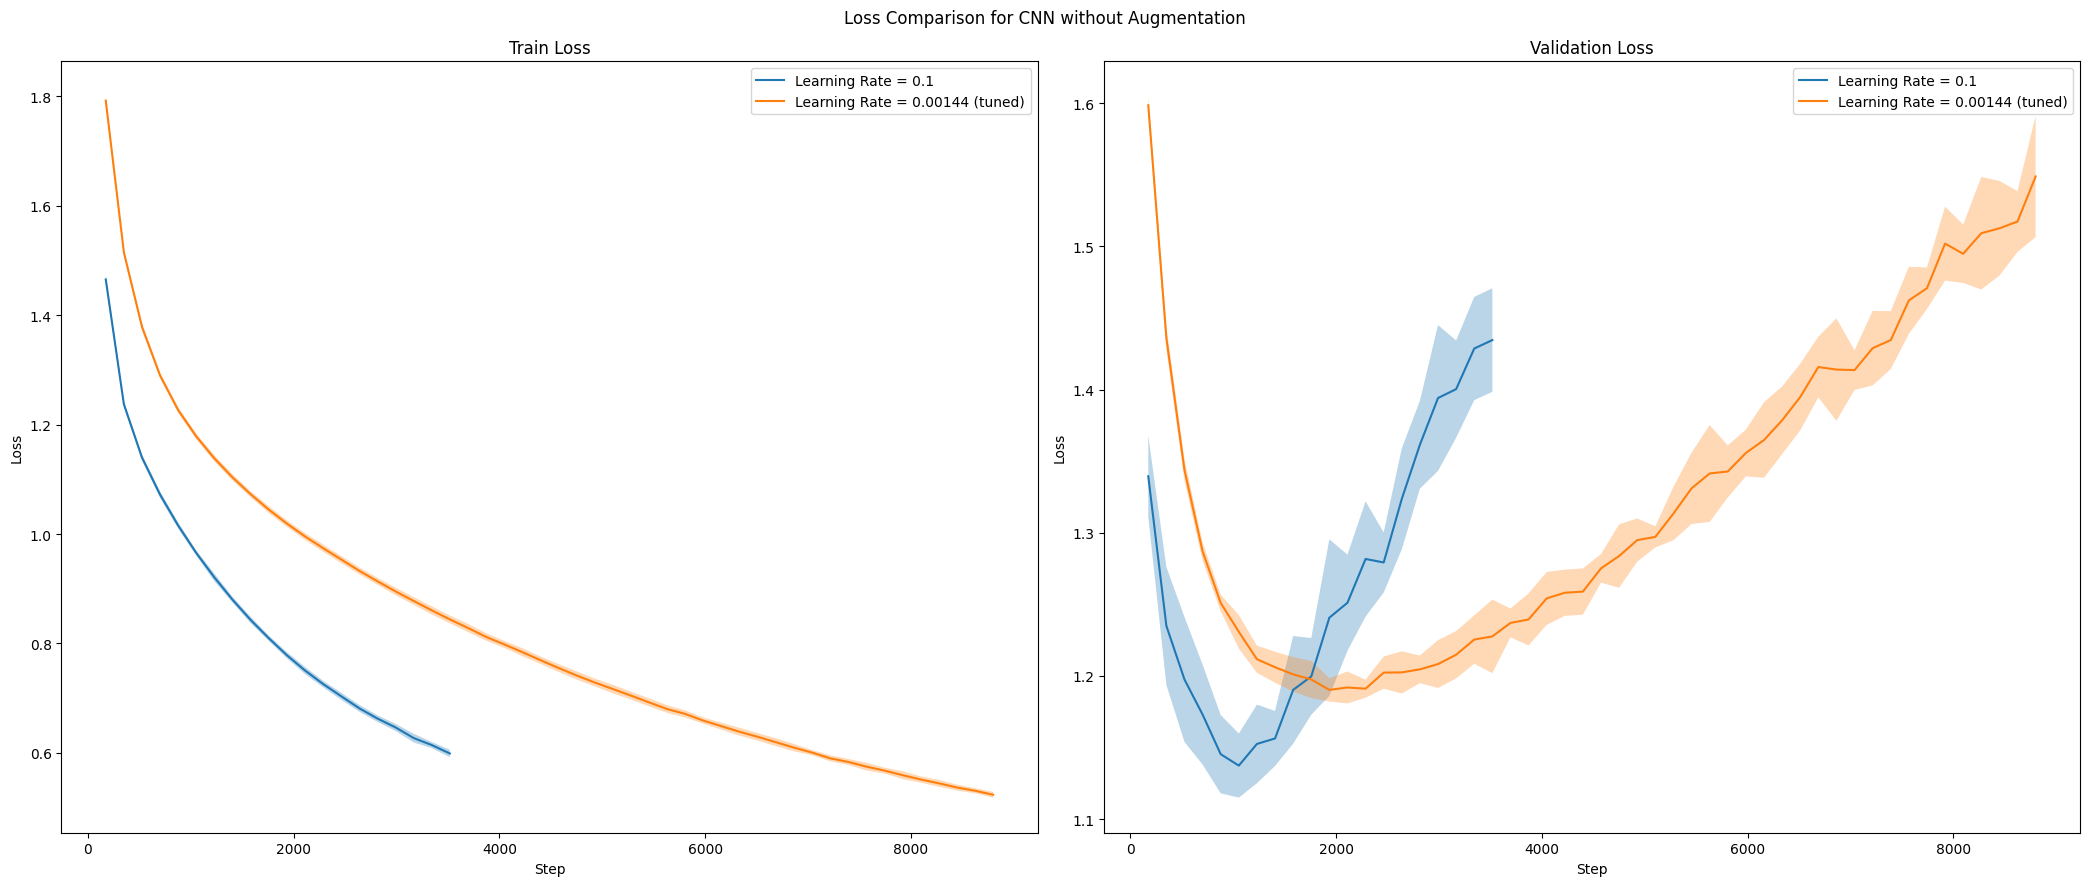

In [28]:
no_aug_best_run_ids = no_aug_best["run_id"].tolist()
no_aug_best_lr_run_ids = no_aug_best_lr["run_id"].tolist()

plot_results(
    no_aug_best_run_ids,
    no_aug_best_lr_run_ids,
    "Learning Rate = 0.1",
    "Learning Rate = 0.00144 (tuned)",
    "Loss Comparison for CNN without Augmentation",
)

Statistics for Tuned Learning Rate - no augmentation: 
Overall mean train loss: 0.8330275997850631
Overall mean val loss: 1.3260493493080139
Overall std train loss: 0.006703363755407903
Overall std val loss: 0.01709031752671498

Statistics for Tuned Learning Rate - augmentation: 
Overall mean train loss no aug: 1.4565315955215028
Overall mean val loss no aug: 1.4168308370643192
Overall std train loss no aug: 0.0045862478170434285
Overall std val loss no aug: 0.008306723074501234


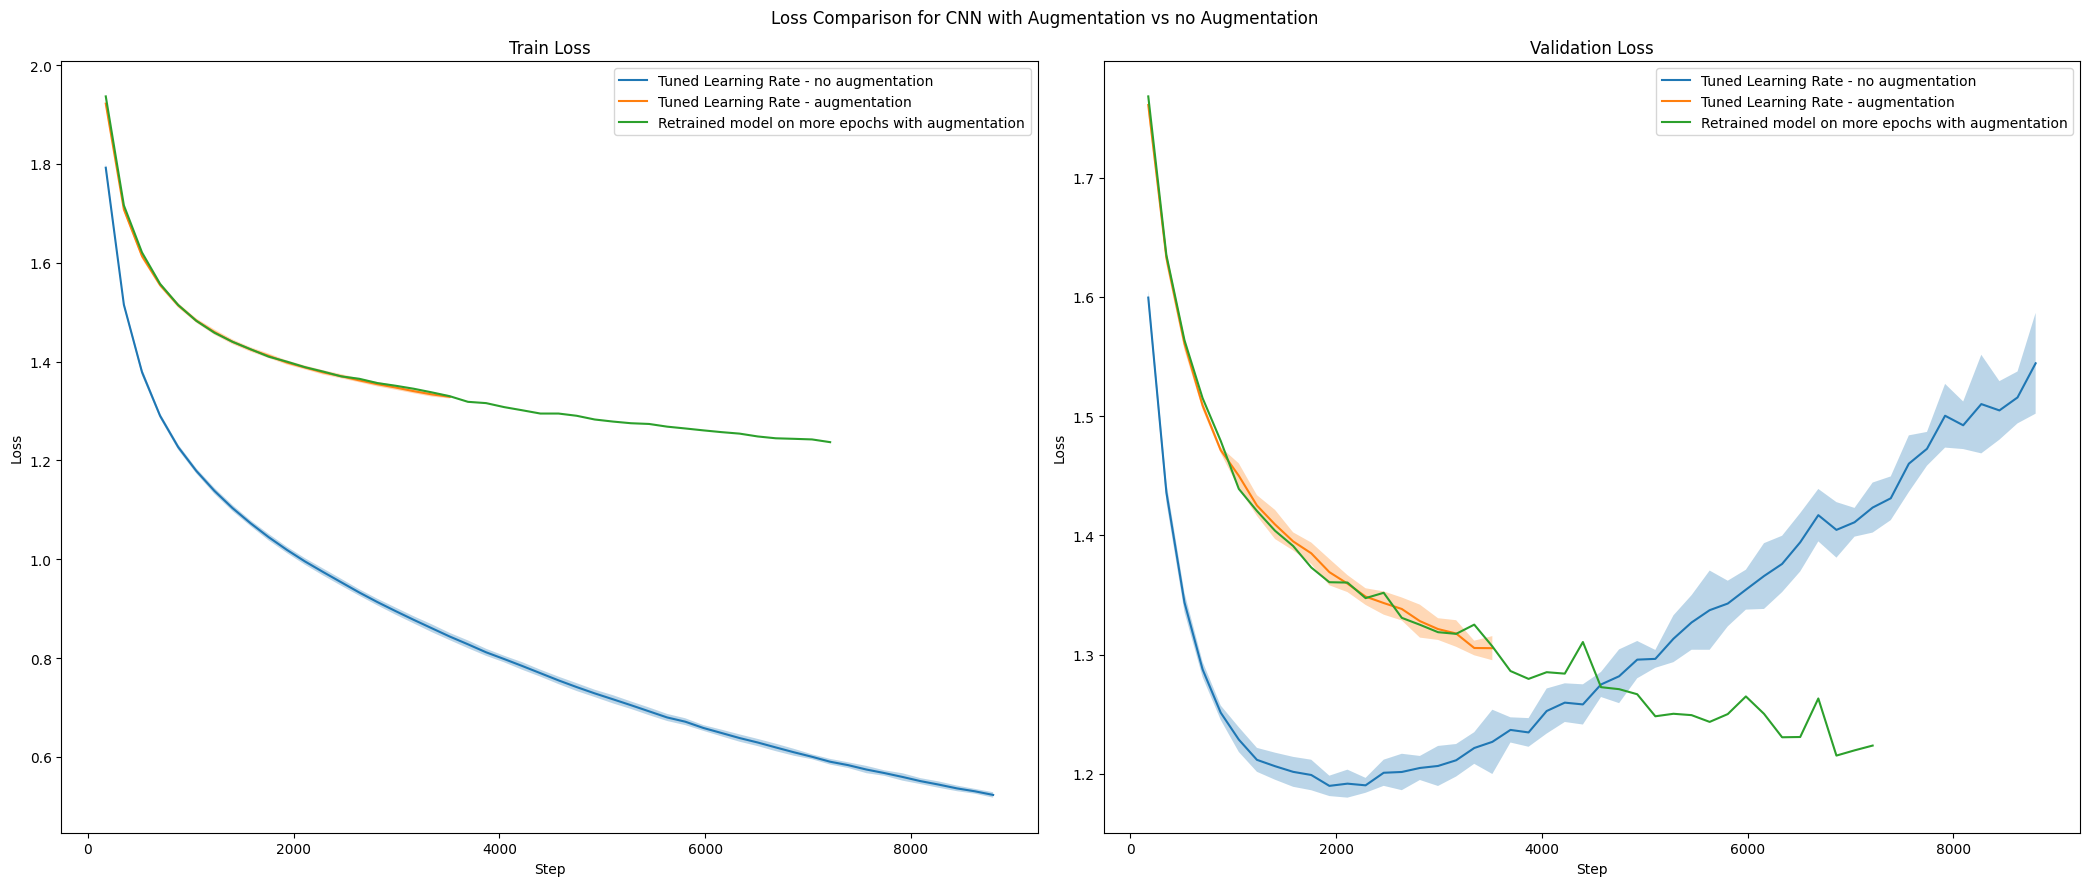

In [31]:
aug_best_lr = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.learning_rate = "0.0014454397707459282" ',
)
aug_best_lr_run_ids = aug_best_lr["run_id"].tolist()

plot_results(
    no_aug_best_lr_run_ids,
    aug_best_lr_run_ids[1:],
    "Tuned Learning Rate - no augmentation",
    "Tuned Learning Rate - augmentation",
    "Loss Comparison for CNN with Augmentation vs no Augmentation",
    [aug_best_lr_run_ids[0]],
    "Retrained model on more epochs with augmentation",
)

In [55]:
def plot_results_compare3(
    aug_ids,
    other_ids,
    label1,
    label2,
    title,
    additional_ids=None,
    additional_label=None,
):
    all_train_loss_aug = []
    all_val_loss_aug = []
    steps1 = None
    steps2 = None
    all_train_loss_no_aug = []
    all_val_loss_no_aug = []
    for run_id_aug, run_id_no_aug in zip(aug_ids, other_ids):
        metrics_aug = get_per_step_value(run_id_aug)
        train_loss_steps, train_loss_values = metrics_aug["train_loss"]
        _, val_loss_values = metrics_aug["val_loss"]
        metrics_no_aug = get_per_step_value(run_id_no_aug)
        train_loss_steps2, train_loss_values_no_aug = metrics_no_aug["train_loss"]
        _, val_loss_values_no_aug = metrics_no_aug["val_loss"]
        all_train_loss_aug.append(train_loss_values)
        all_val_loss_aug.append(val_loss_values)
        all_train_loss_no_aug.append(train_loss_values_no_aug)
        all_val_loss_no_aug.append(val_loss_values_no_aug)
        if steps1 is None:
            steps1 = train_loss_steps
        if steps2 is None:
            steps2 = train_loss_steps2

    additional_train_loss = []
    additional_val_loss = []
    steps3 = None
    if additional_ids is not None:
        for run_id in additional_ids:
            metrics = get_per_step_value(run_id)
            train_loss_steps3, train_loss_values3 = metrics["train_loss"]
            _, val_loss_values3 = metrics["val_loss"]
            additional_train_loss.append(train_loss_values3)
            additional_val_loss.append(val_loss_values3)
            if steps3 is None:
                steps3 = train_loss_steps3
    train_loss_values = np.array(all_train_loss_aug)
    val_loss_values = np.array(all_val_loss_aug)
    train_loss_values_no_aug = np.array(all_train_loss_no_aug)
    val_loss_values_no_aug = np.array(all_val_loss_no_aug)
    mean_train_loss = np.mean(train_loss_values, axis=0)
    mean_val_loss = np.mean(val_loss_values, axis=0)
    std_train_loss = np.std(train_loss_values, axis=0)
    std_val_loss = np.std(val_loss_values, axis=0)
    mean_train_loss_no_aug = np.mean(train_loss_values_no_aug, axis=0)
    mean_val_loss_no_aug = np.mean(val_loss_values_no_aug, axis=0)
    std_train_loss_no_aug = np.std(train_loss_values_no_aug, axis=0)
    std_val_loss_no_aug = np.std(val_loss_values_no_aug, axis=0)
    additional_train_loss = np.array(additional_train_loss)
    additional_val_loss = np.array(additional_val_loss)
    mean_train_loss_values3 = np.mean(additional_train_loss, axis=0)
    std_train_loss_values3 = np.std(additional_train_loss, axis=0)
    mean_val_loss_values3 = np.mean(additional_val_loss, axis=0)
    std_val_loss_values3 = np.std(additional_val_loss, axis=0)
    fig, axs = plt.subplots(1, 2, figsize=(21, 9))
    # Subplot 1: Train Loss
    axs[0].plot(steps1, mean_train_loss, label=label1)
    axs[0].fill_between(
        steps1,
        mean_train_loss - std_train_loss,
        mean_train_loss + std_train_loss,
        alpha=0.3,
    )
    axs[0].plot(steps2, mean_train_loss_no_aug, label=label2)
    axs[0].fill_between(
        steps2,
        mean_train_loss_no_aug - std_train_loss_no_aug,
        mean_train_loss_no_aug + std_train_loss_no_aug,
        alpha=0.3,
    )

    axs[0].plot(steps3, mean_train_loss_values3, label=additional_label)
    axs[0].fill_between(
        steps3,
        mean_train_loss_values3 - std_train_loss_values3,
        mean_train_loss_values3 + std_train_loss_values3,
        alpha=0.3,
    )
    axs[0].set_title("Train Loss")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Subplot 2: Validation Loss
    axs[1].plot(steps1, mean_val_loss, label=label1)
    axs[1].fill_between(
        steps1, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3
    )
    axs[1].plot(steps2, mean_val_loss_no_aug, label=label2)
    axs[1].fill_between(
        steps2,
        mean_val_loss_no_aug - std_val_loss_no_aug,
        mean_val_loss_no_aug + std_val_loss_no_aug,
        alpha=0.3,
    )
    axs[1].plot(steps3, mean_val_loss_values3, label=additional_label)
    axs[1].fill_between(
        steps3,
        mean_val_loss_values3 - std_val_loss_values3,
        mean_val_loss_values3 + std_val_loss_values3,
        alpha=0.3,
    )
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    fig.suptitle(title)
    plt.tight_layout()
    print(f"Statistics for {label1}: ")
    print("Overall mean train loss:", np.mean(mean_train_loss))
    print("Overall mean val loss:", np.mean(mean_val_loss))
    print("Overall std train loss:", np.mean(std_train_loss))
    print("Overall std val loss:", np.mean(std_val_loss))
    print(f"\nStatistics for {label2}: ")
    print("Overall mean train loss no aug:", np.mean(mean_train_loss_no_aug))
    print("Overall mean val loss no aug:", np.mean(mean_val_loss_no_aug))
    print("Overall std train loss no aug:", np.mean(std_train_loss_no_aug))
    print("Overall std val loss no aug:", np.mean(std_val_loss_no_aug))
    print(f"\nStatistics for {additional_label}: ")
    print("Overall mean train loss no aug:", np.mean(mean_train_loss_values3))
    print("Overall mean val loss no aug:", np.mean(mean_val_loss_values3))
    print("Overall std train loss no aug:", np.mean(std_train_loss_values3))
    print("Overall std val loss no aug:", np.mean(std_val_loss_values3))
    plt.show()

Statistics for Batch Size = 1024: 
Overall mean train loss: 1.3560676797440174
Overall mean val loss: 1.3588348677283841
Overall std train loss: 0.030847727414236963
Overall std val loss: 0.046107423954310243

Statistics for Batch Size = 512: 
Overall mean train loss no aug: 1.3782153746015147
Overall mean val loss no aug: 1.3541512781067901
Overall std train loss no aug: 0.053688120534920294
Overall std val loss no aug: 0.04962732706272478


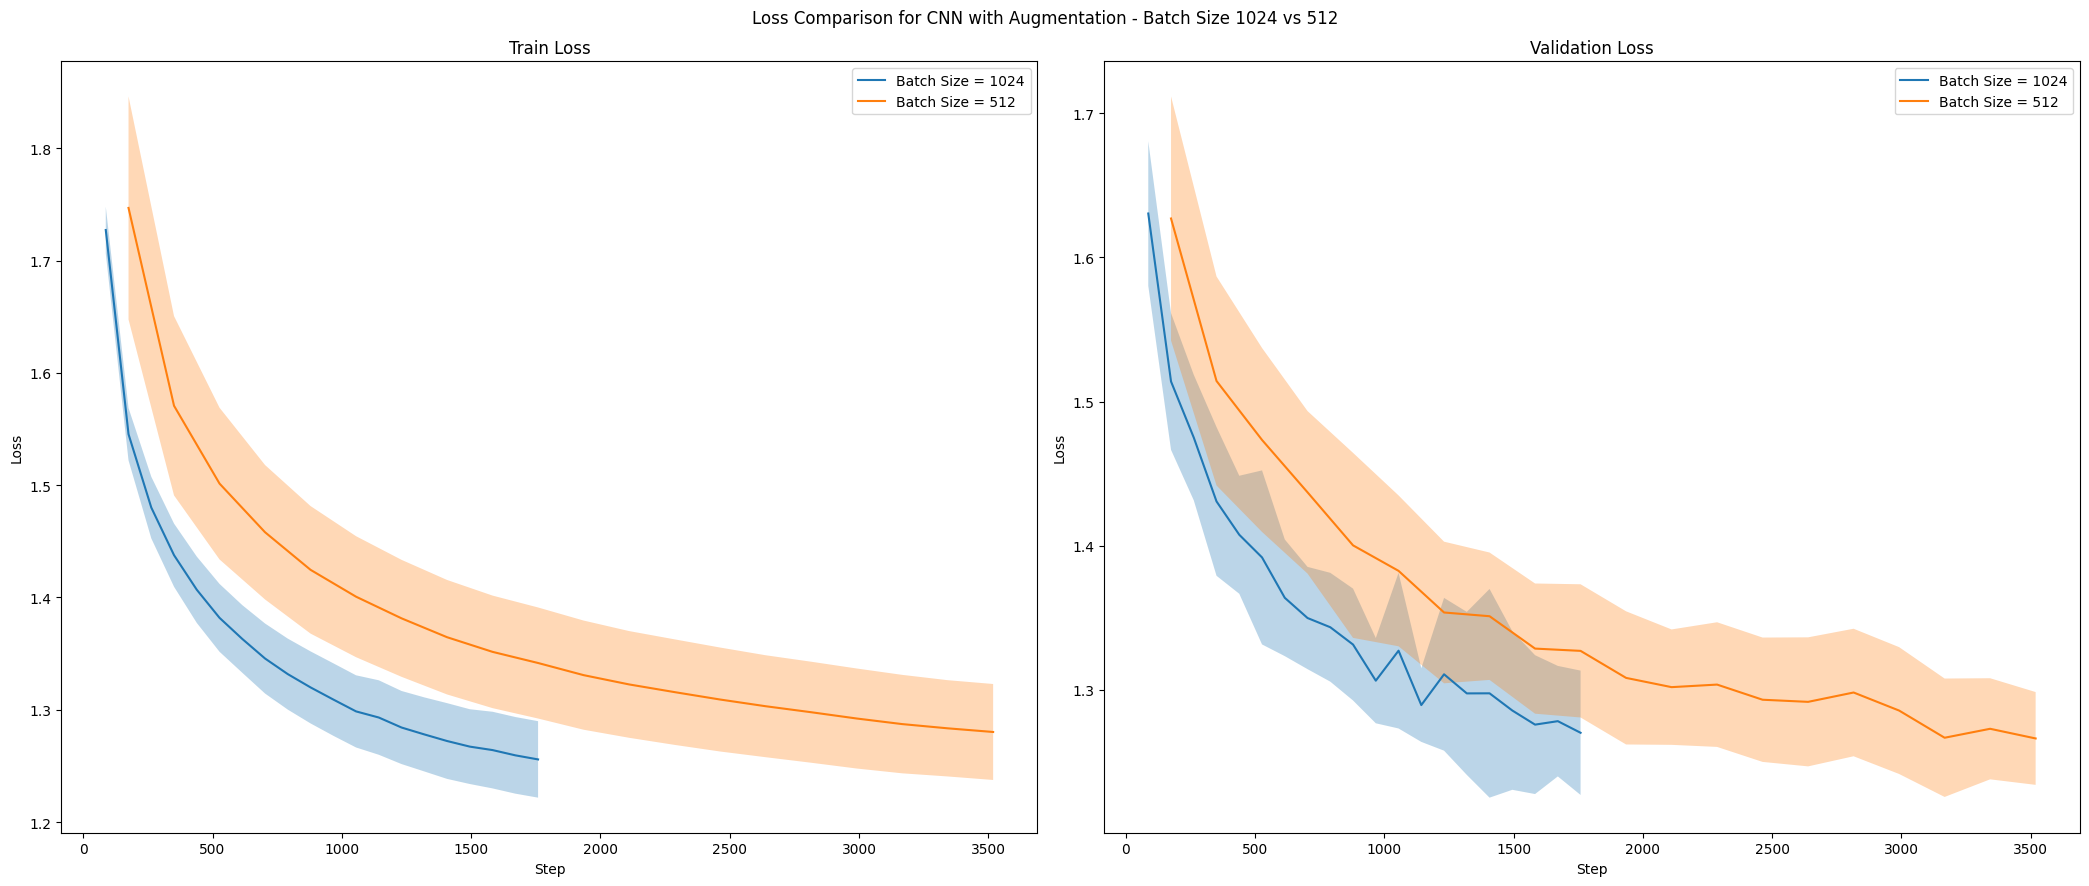

In [49]:
# batch size: 512, 1024
aug_batch_512 = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.batch_size = "512" and metric.epoch = 20',
)
aug_batch_1024 = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.batch_size = "1024" and metric.epoch = 20',
)
aug_batch_128 = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.batch_size = "128" and metric.epoch = 20',
)
aug_batch_512_run_ids = aug_batch_512["run_id"].tolist()
aug_batch_1024_run_ids = aug_batch_1024["run_id"].tolist()
aug_batch_128_run_ids = aug_batch_128["run_id"].tolist()

plot_results(
    aug_batch_1024_run_ids,
    aug_batch_512_run_ids,
    "Batch Size = 1024",
    "Batch Size = 512",
    "Loss Comparison for CNN with Augmentation - Batch Size 1024 vs 512",
)

In [44]:
# compare dropouts: 0.2, 0.3, 0.4
aug_dropout_0_2 = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.dropout = "0.2" and metric.epoch = 20',
)
aug_dropout_0_3 = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.dropout = "0.3" and metric.epoch = 20',
)
aug_dropout_0_4 = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.dropout = "0.4" and metric.epoch = 20',
)
aug_dropout_0_2_run_ids = aug_dropout_0_2["run_id"].tolist()
aug_dropout_0_3_run_ids = aug_dropout_0_3["run_id"].tolist()
aug_dropout_0_4_run_ids = aug_dropout_0_4["run_id"].tolist()
print(len(aug_dropout_0_2_run_ids))
print(len(aug_dropout_0_3_run_ids))
print(len(aug_dropout_0_4_run_ids))

38
32
30


Statistics for Dropout = 0.3: 
Overall mean train loss: 1.3584037847816943
Overall mean val loss: 1.3491336250677706
Overall std train loss: 0.008297643076600735
Overall std val loss: 0.042234025951780406

Statistics for Dropout = 0.2: 
Overall mean train loss no aug: 1.3561184331774712
Overall mean val loss no aug: 1.3530144110321998
Overall std train loss no aug: 0.06330361187887723
Overall std val loss no aug: 0.0527678707972705

Statistics for Dropout = 0.4: 
Overall mean train loss no aug: 1.526208015481631
Overall mean val loss no aug: 1.4816236833731335
Overall std train loss no aug: 0.1824231797878501
Overall std val loss no aug: 0.16781832322102655


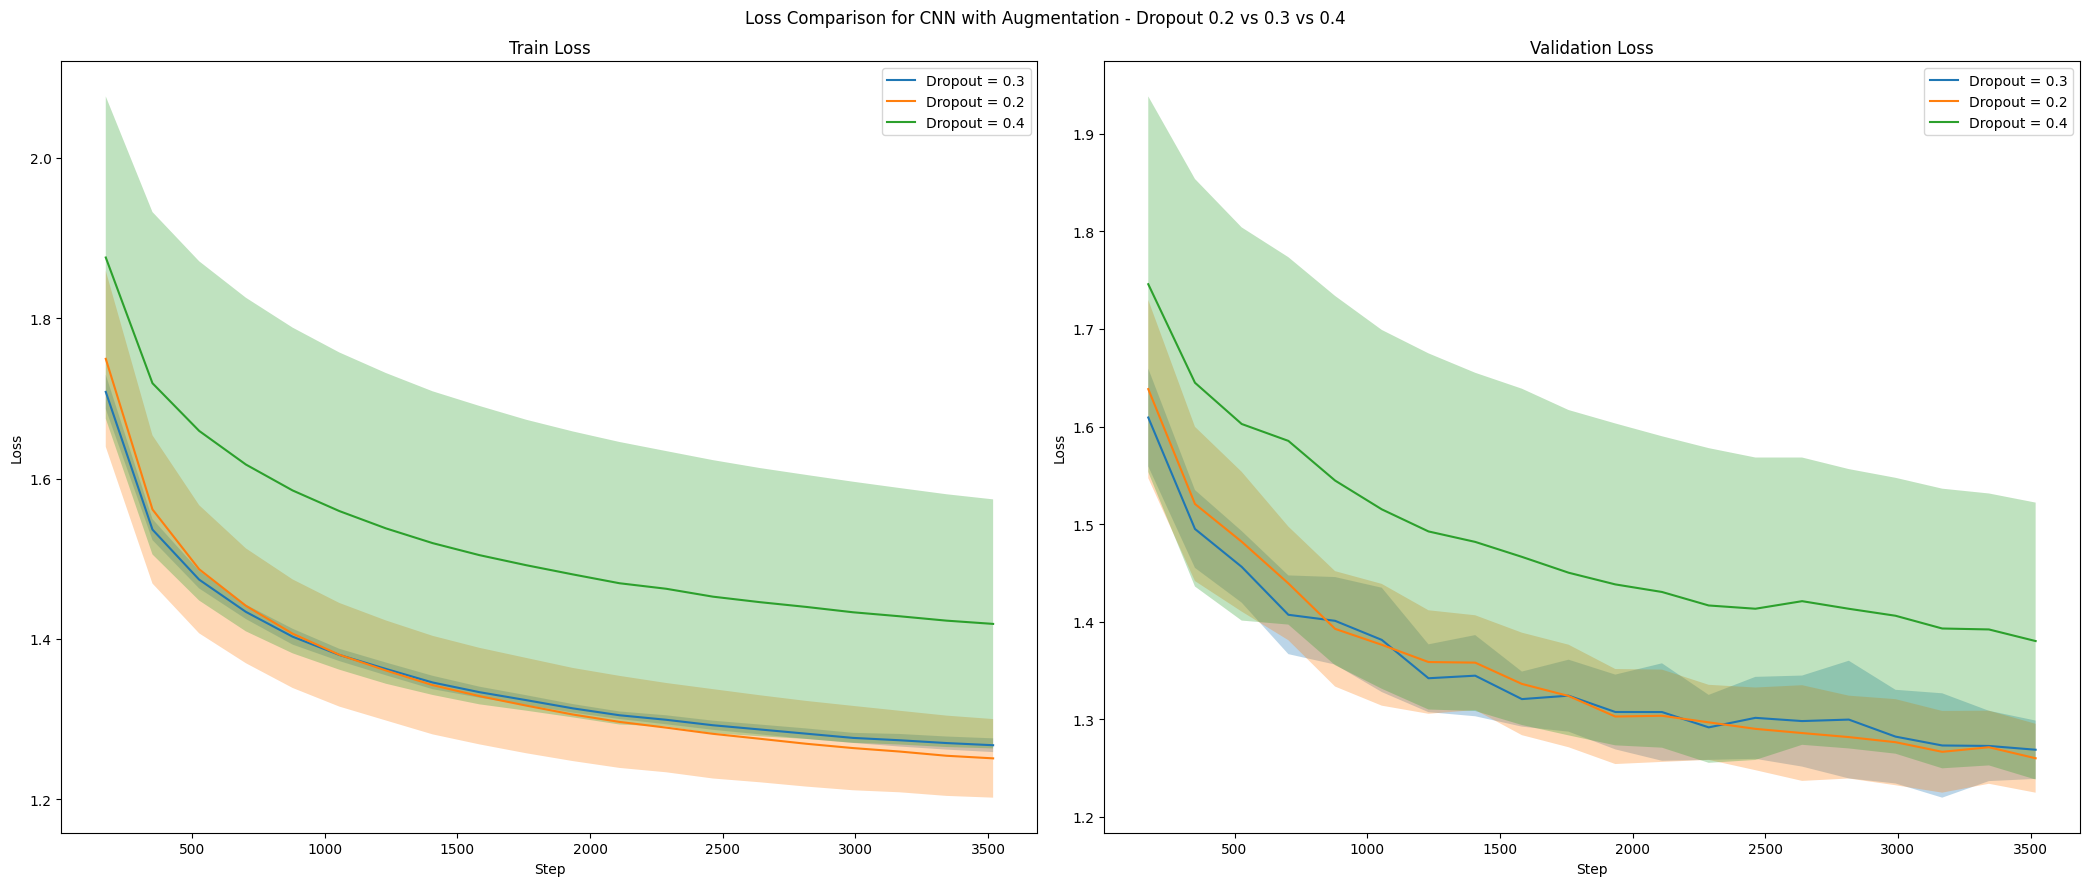

In [56]:
plot_results_compare3(
    aug_dropout_0_3_run_ids,
    aug_dropout_0_2_run_ids,
    "Dropout = 0.3",
    "Dropout = 0.2",
    "Loss Comparison for CNN with Augmentation - Dropout 0.2 vs 0.3 vs 0.4",
    aug_dropout_0_4_run_ids,
    "Dropout = 0.4",
)

In [ ]:
def align_runs(run_values):
    """
    Truncate all runs to the minimum number of epochs.
    Returns:
      mean_train, std_train, mean_val, std_val: arrays computed over epochs.
    """
    # Find the minimum number of epochs among runs
    min_epochs = min(len(v["train_loss"][1]) for v in run_values)

    # Truncate each run to the first min_epochs epochs
    train_losses = np.array([v["train_loss"][1][:min_epochs] for v in run_values])
    val_losses = np.array([v["val_loss"][1][:min_epochs] for v in run_values])

    # Compute mean and standard deviation across runs (axis=0 corresponds to epoch-wise)
    mean_train = np.mean(train_losses, axis=0)
    std_train = np.std(train_losses, axis=0)
    mean_val = np.mean(val_losses, axis=0)
    std_val = np.std(val_losses, axis=0)

    return mean_train, std_train, mean_val, std_val

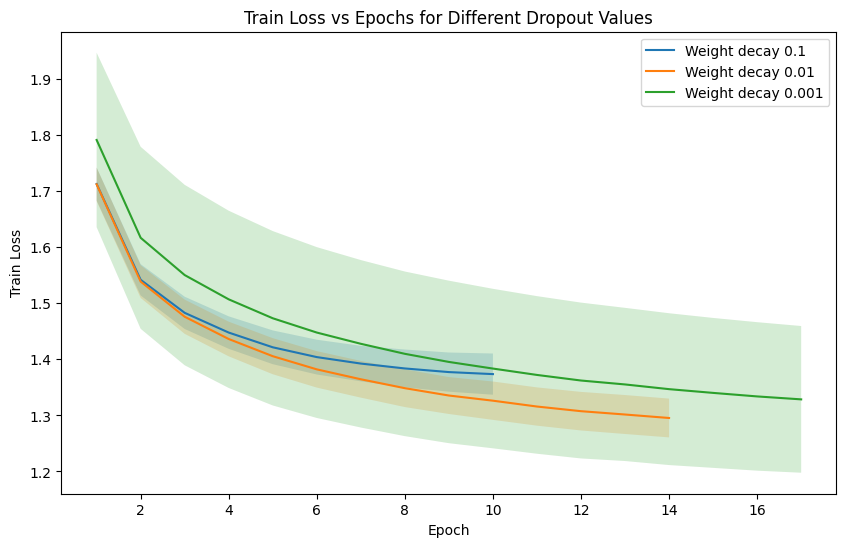

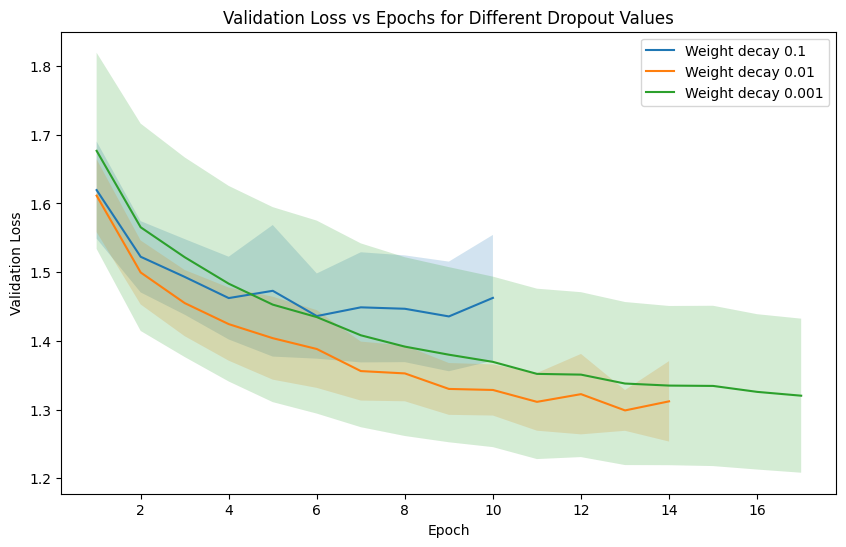

In [71]:
# compare weight decays: 0.1, 0.01, 0.001
aug_wd_0_1 = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.weight_decay = "0.1" and status = "FINISHED"',
)
aug_wd_0_01 = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.weight_decay = "0.01" and status = "FINISHED"',
)
aug_wd_0_001 = mlflow.search_runs(
    cnn_augmentation.experiment_id,
    filter_string='params.weight_decay = "0.001" and status = "FINISHED"',
)
aug_wd_0_1_run_ids = aug_wd_0_1["run_id"].tolist()
aug_wd_0_01_run_ids = aug_wd_0_01["run_id"].tolist()
aug_wd_0_001_run_ids = aug_wd_0_001["run_id"].tolist()


aug_wd_0_1_values = [get_per_step_value(run_id) for run_id in aug_wd_0_1_run_ids]
aug_wd_0_01_values = [get_per_step_value(run_id) for run_id in aug_wd_0_01_run_ids]
aug_wd_0_001_values = [get_per_step_value(run_id) for run_id in aug_wd_0_001_run_ids]

mean_train_0_1, std_train_0_1, mean_val_0_1, std_val_0_1 = align_runs(aug_wd_0_1_values)
mean_train_0_01, std_train_0_01, mean_val_0_01, std_val_0_01 = align_runs(
    aug_wd_0_01_values
)
mean_train_0_001, std_train_0_001, mean_val_0_001, std_val_0_001 = align_runs(
    aug_wd_0_001_values
)

epochs_0_1 = np.arange(1, len(mean_train_0_1) + 1)
epochs_0_01 = np.arange(1, len(mean_train_0_01) + 1)
epochs_0_001 = np.arange(1, len(mean_train_0_001) + 1)
plt.figure(figsize=(10, 6))
# Plotting dropout 0.1
plt.plot(epochs_0_1, mean_train_0_1, label="Weight decay 0.1")
plt.fill_between(
    epochs_0_1,
    mean_train_0_1 - std_train_0_1,
    mean_train_0_1 + std_train_0_1,
    alpha=0.2,
)
# Plotting dropout 0.01
plt.plot(epochs_0_01, mean_train_0_01, label="Weight decay 0.01")
plt.fill_between(
    epochs_0_01,
    mean_train_0_01 - std_train_0_01,
    mean_train_0_01 + std_train_0_01,
    alpha=0.2,
)
# Plotting dropout 0.001
plt.plot(epochs_0_001, mean_train_0_001, label="Weight decay 0.001")
plt.fill_between(
    epochs_0_001,
    mean_train_0_001 - std_train_0_001,
    mean_train_0_001 + std_train_0_001,
    alpha=0.2,
)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss vs Epochs for Different Dropout Values")
plt.legend()
plt.show()

val_epochs_0_1 = np.arange(1, len(mean_val_0_1) + 1)
val_epochs_0_01 = np.arange(1, len(mean_val_0_01) + 1)
val_epochs_0_001 = np.arange(1, len(mean_val_0_001) + 1)

plt.figure(figsize=(10, 6))
plt.plot(val_epochs_0_1, mean_val_0_1, label="Weight decay 0.1")
plt.fill_between(
    val_epochs_0_1,
    mean_val_0_1 - std_val_0_1,
    mean_val_0_1 + std_val_0_1,
    alpha=0.2,
)

plt.plot(val_epochs_0_01, mean_val_0_01, label="Weight decay 0.01")
plt.fill_between(
    val_epochs_0_01,
    mean_val_0_01 - std_val_0_01,
    mean_val_0_01 + std_val_0_01,
    alpha=0.2,
)
plt.plot(val_epochs_0_001, mean_val_0_001, label="Weight decay 0.001")
plt.fill_between(
    val_epochs_0_001,
    mean_val_0_001 - std_val_0_001,
    mean_val_0_001 + std_val_0_001,
    alpha=0.2,
)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs for Different Dropout Values")
plt.legend()
plt.show()